### ImagesClassificationWithSIFT with zca_whitening_parameter to True and featurewise_std_normalization_parameter to False

In [1]:
## To display the graphs within the code and not in another windows 
import sys
print("Python Version :"+str(sys.version_info))
%matplotlib inline
# To be able to use CSV
import csv
print("CSV Version :"+csv.__version__)
# To be able to use Numpy
import numpy as np
print("Numpy Version :"+np.__version__)
# To be able to use Pandas
import pandas as pd
print("Pandas Version :"+pd.__version__)
# To be able to use Maplotlib
import matplotlib.pyplot as plt

# To be able to use Seaborn
import seaborn as sns
print("Seaborn Version :"+sns.__version__)


# import scipy as sio
# print("Scipy Version :"+sio.__version__)
import scipy.io as sio
import os
import shutil
import random
import cv2 as cv
print("OpenCV Version : "+cv.__version__)
from PIL import Image

# To be able to use Warning
import warnings
import sklearn
print("Sklearn Version : "+sklearn.__version__)
from sklearn.cluster import MiniBatchKMeans
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder, normalize
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.manifold import TSNE
from catboost import CatBoostClassifier
import catboost
print("Catboost Version : "+catboost.__version__)
from catboost import CatBoostClassifier
# from utils import plot_confusion_matrix

from keras.preprocessing.image import load_img, img_to_array
from keras.applications.xception import preprocess_input
from keras.applications import *
from keras.applications.xception import decode_predictions
from keras.layers import Dense
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import *
import tensorflow as tf
print("Keras Version : "+tf.keras.__version__)
print("Tensorflow Version : "+tf.__version__)

Python Version :sys.version_info(major=3, minor=7, micro=7, releaselevel='final', serial=0)
CSV Version :1.0
Numpy Version :1.18.5
Pandas Version :1.0.5
Seaborn Version :0.10.1
OpenCV Version : 3.4.2
Sklearn Version : 0.23.1
Catboost Version : 0.24


Using TensorFlow backend.


Keras Version : 2.2.4-tf
Tensorflow Version : 2.1.0


In [2]:
images_directory = './images/Images/'
# train_contents = sio.loadmat('./lists/train_list.mat')
# test_contents = sio.loadmat('./lists/test_list.mat')
# file_list = sio.loadmat('./lists/file_list.mat')
train_directory = './images/train/'
test_directory = './images/test/'

### Rename the folder names

In [ ]:
def convert(word):
    return ''.join(x.capitalize() or '_' for x in word.split('_'))

In [ ]:
for root, dirs, files in os.walk(images_directory):
    for count in dirs:
        print(convert(count.split('-')[1].capitalize()))
        os.rename(os.path.join(images_directory, count), os.path.join(images_directory, convert(count.split('-')[1].capitalize())))


### Creation of the  train test directory

In [ ]:
train_dir = './images/train/'
test_dir = './images/test/'


In [ ]:
files = [file for file in os.listdir(images_directory) if os.path.isfile(os.path.join(images_directory, file))]

In [ ]:
directories = [directory for directory in os.listdir(images_directory)]

In [ ]:
directories

In [ ]:
for directory in directories:
    os.mkdir(train_dir+directory)
    os.mkdir(test_dir+directory)

### Split train test

In [ ]:
directories

In [ ]:
for directory in directories:
    files = [file for file in os.listdir(images_directory+directory) if os.path.isfile(os.path.join(images_directory+directory, file))]
    train_count  = np.round(70/100*len(files))
    test_count = np.round(30/100*len(files))
    rndnums = list(random.sample(range(0, len(files)), len(files)))
    print("len(files)",len(files))
    train_file_index = rndnums[0:int(train_count)+1]
    train_file_name = [files[i] for i in train_file_index]
    test_file_index = rndnums[int(train_count)+1:int(train_count + test_count)+1]
    test_file_name = [files[i] for i in test_file_index]
    for x in train_file_name:
        file = x
        shutil.copyfile(os.path.join(images_directory+directory, file), os.path.join(train_directory+directory, file))
    ##test_files
    for y in test_file_name:
        file = y
        shutil.copyfile(os.path.join(images_directory+directory, file), os.path.join(test_directory+directory, file))

    

In [ ]:
train_file_name

In [3]:
input_directory='./images/'
output_directory='./new_images/'
small_directory_names = [directory for directory in os.listdir(input_directory+'train-small')]
small_directory_names.sort()
zca_whitening_parameter=True
featurewise_std_normalization_parameter=False
color_mode_parameter='grayscale'
save_prefix_parameter='set1_'
batch_size=2
follow_links=True
train_datagen = ImageDataGenerator(
        rescale=1./255,
        zca_whitening=zca_whitening_parameter,
        featurewise_std_normalization=featurewise_std_normalization_parameter
        )

/home/david/anaconda3/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:336: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


In [4]:
small_directory_names

['Basset', 'Cardigan', 'OldEnglishSheepdog']

In [5]:
myCategories = dict(enumerate(small_directory_names))

In [6]:
myCategories

{0: 'Basset', 1: 'Cardigan', 2: 'OldEnglishSheepdog'}

In [7]:
train_generator = train_datagen.flow_from_directory(input_directory+'train-small', target_size=(224, 224), follow_links=True, batch_size=batch_size, class_mode='categorical', save_format='jpeg', classes=small_directory_names, subset='training', shuffle=False, color_mode=color_mode_parameter)

Found 350 images belonging to 3 classes.


In [8]:
test_generator = train_datagen.flow_from_directory(input_directory+'test-small', target_size=(224, 224), follow_links=True, batch_size=batch_size, class_mode='categorical', save_format='jpeg', classes=small_directory_names, shuffle=False, color_mode=color_mode_parameter)

Found 148 images belonging to 3 classes.


In [9]:
train_df = pd.DataFrame(columns=["Category", "Picture","Descriptors", "NumberOfDescriptors"])

In [10]:
test_df = pd.DataFrame(columns=["Category", "Picture","Descriptors", "NumberOfDescriptors"])

### Compute the descriptors  and add them with the category into a dataframe

In [11]:
algo_constructor = cv.xfeatures2d.SIFT_create()
def computeDescriptors(mygenerator, mydf, mydescriptors):
    count = 0
    for i in range(len(mygenerator)):
    #next(train_generator)
        for j in range(batch_size):
            img = mygenerator[i][0][j].squeeze()
            imgwithrgb = cv.merge([img, img, img])
            image8bit = cv.normalize(imgwithrgb, None, 0, 255, cv.NORM_MINMAX).astype('uint8')
            keypoints, descriptors = algo_constructor.detectAndCompute(image8bit, None)
            mydf = mydf.append({'Category': mygenerator[i][1][j].tolist().index(1), 'Picture':image8bit, 'Descriptors':descriptors, 'NumberOfDescriptors':descriptors.shape[0]}, ignore_index='True')
            mydescriptors.extend(descriptors)
            count = count + 1
            j = j+1
    i = i+1
    mydf['Category'] = mydf['Category'].map(myCategories) 
    return mydf, mydescriptors

### Train 

In [12]:
train_descriptors_array=[]
train_df, train_descriptors_array=computeDescriptors(train_generator, train_df, train_descriptors_array)

/home/david/anaconda3/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/david/anaconda3/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:735: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


In [ ]:
plt.imshow(train_df['Picture'][0])
plt.show()

In [ ]:
fig, axs = plt.subplots(1, 6, figsize=(60, 12))
axs[0].set_title('An Original Picture in grayscale  ', fontsize=20)
axs[0].imshow(train_df['Picture'][0], cmap='Greys_r')
axs[1].set_title('Histogram of an original Picture in grayscale ', fontsize=20)
axs[1].set_xlabel('Level of gray', fontsize=20)
axs[1].set_ylabel('Number of pixels', fontsize=20)
axs[1].hist(train_df['Picture'][0].ravel(), 256, [0, 256])


### Test

In [13]:
test_descriptors_array=[]
test_df, test_descriptors_array=computeDescriptors(test_generator, test_df, test_descriptors_array)

In [14]:
print(train_df['NumberOfDescriptors'].sum())

113360


In [15]:
print(test_df['NumberOfDescriptors'].sum())

46444


### Apply a Kmeans to get clusters

In [16]:
# A k-means clustering algorithm who takes 2 parameter which is number
# of cluster(k) and the other is descriptors list(unordered 1d array)
# Returns an array that holds central points.
def kmeans(k, descriptor_list):
    # kmeans = KMeans(n_clusters=k, n_init=10)
    mymodel = MiniBatchKMeans(n_clusters=k, n_init=10)
    mymodel.fit(descriptor_list)
    visual_words = mymodel.cluster_centers_
    labels = mymodel.labels_
    silhouette_score = metrics.silhouette_score(descriptor_list, labels)
    calinski_harabasz_score = metrics.calinski_harabasz_score(descriptor_list, labels)
    print('silhouette_score '+str(silhouette_score))
    print('calinski_harabasz_score '+str(calinski_harabasz_score))
    return mymodel, visual_words, labels
# Takes the central points which is visual words
model, visual_words, labels = kmeans(150, train_descriptors_array)

silhouette_score 0.029367475
calinski_harabasz_score 556.8175094548268


In [17]:
X_train = pd.DataFrame(columns=range(len(visual_words)))
X_test = pd.DataFrame(columns=range(len(visual_words)))

In [18]:
for index, row in train_df.iterrows():
    labels = model.predict(pd.DataFrame(row["Descriptors"]).astype(float))
    unique, counts = np.unique(labels, return_counts=True)
    X_train = X_train.append(dict(zip(unique, counts)), ignore_index=True)

In [19]:
X_train.fillna(0, inplace=True)

In [20]:
X_train

,0,1,2,3,4,5,6,7,8,9,...,140,141,142,143,144,145,146,147,148,149
0,1.0,3.0,3.0,9.0,2.0,8.0,11.0,4.0,4.0,1.0,...,6.0,0.0,4.0,4.0,6.0,0.0,5.0,2.0,2.0,8.0
1,1.0,3.0,5.0,0.0,0.0,1.0,2.0,1.0,0.0,0.0,...,2.0,1.0,1.0,2.0,3.0,0.0,0.0,0.0,1.0,1.0
2,2.0,2.0,2.0,6.0,5.0,3.0,4.0,8.0,2.0,8.0,...,4.0,4.0,2.0,0.0,2.0,0.0,1.0,1.0,1.0,3.0
3,3.0,4.0,3.0,11.0,1.0,2.0,10.0,1.0,3.0,5.0,...,4.0,2.0,5.0,1.0,2.0,0.0,1.0,0.0,0.0,3.0
4,2.0,3.0,0.0,12.0,2.0,3.0,16.0,1.0,0.0,4.0,...,3.0,4.0,0.0,0.0,11.0,2.0,3.0,0.0,5.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
345,3.0,2.0,4.0,3.0,1.0,0.0,1.0,4.0,6.0,4.0,...,0.0,0.0,4.0,0.0,1.0,2.0,0.0,4.0,1.0,0.0
346,2.0,15.0,1.0,2.0,2.0,1.0,0.0,1.0,3.0,1.0,...,0.0,0.0,1.0,0.0,1.0,3.0,1.0,0.0,1.0,0.0
347,5.0,6.0,2.0,3.0,2.0,6.0,2.0,1.0,5.0,0.0,...,1.0,1.0,1.0,2.0,2.0,0.0,1.0,3.0,9.0,4.0
348,3.0,3.0,2.0,0.0,1.0,1.0,0.0,2.0,3.0,1.0,...,1.0,0.0,1.0,1.0,1.0,0.0,0.0,3.0,4.0,1.0


In [ ]:
train_df

In [21]:
for index, row in test_df.iterrows():
    labels = model.predict(pd.DataFrame(row["Descriptors"]).astype(float))
    unique, counts = np.unique(labels, return_counts=True)
    X_test = X_test.append(dict(zip(unique, counts)), ignore_index=True)

In [22]:
X_test.fillna(0, inplace=True)

In [ ]:
X_test

In [23]:
le = LabelEncoder().fit(train_df['Category'])

In [24]:
y_train = le.transform(train_df['Category'])
y_test = le.transform(test_df['Category'])

In [ ]:
y_test

### TSNE

In [25]:
X_train_embedded = TSNE(n_components=2).fit_transform(X_train)
X_train_embedded_df = pd.DataFrame(X_train_embedded, columns=['SIFT1', 'SIFT2'])

In [26]:
X_train_embedded_df['Category'] = train_df['Category']

silhouette_score -0.02400181
calinski_harabasz_score 3.4402493461556567


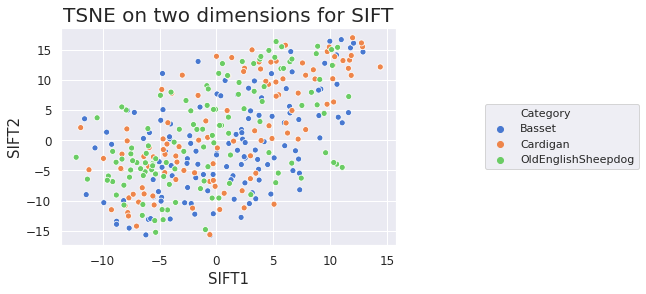

In [27]:
sns.set(palette='muted', color_codes=True, style='darkgrid')
ax = sns.scatterplot(x='SIFT1', y='SIFT2', hue="Category", data=X_train_embedded_df)
ax.set_title('TSNE on two dimensions for SIFT', fontsize=20)
ax.set_xlabel('SIFT1', fontsize=15)
ax.set_ylabel('SIFT2', fontsize=15)
ax.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
ax.tick_params(labelsize=12)
silhouette_score = metrics.silhouette_score(X_train_embedded, train_df['Category'])
calinski_harabasz_score = metrics.calinski_harabasz_score(X_train_embedded, train_df['Category'])
print('silhouette_score '+str(silhouette_score))
print('calinski_harabasz_score '+str(calinski_harabasz_score))

### CatBoostClassifier 

In [28]:
from catboost import CatBoostClassifier

clf = CatBoostClassifier(
    iterations=1000, 
    learning_rate=0.1, 
    #loss_function='CrossEntropy'
)

In [29]:
type(small_directory_names)

list

In [30]:
clf.fit(
    X_train, y_train
    # cat_features=[0, 1, 2]
)

0:	learn: 1.0891612	total: 62.3ms	remaining: 1m 2s
1:	learn: 1.0741319	total: 65.2ms	remaining: 32.5s
2:	learn: 1.0573920	total: 67.8ms	remaining: 22.5s
3:	learn: 1.0435255	total: 70.6ms	remaining: 17.6s
4:	learn: 1.0329336	total: 73.6ms	remaining: 14.6s
5:	learn: 1.0189293	total: 76.3ms	remaining: 12.6s
6:	learn: 1.0041478	total: 79.1ms	remaining: 11.2s
7:	learn: 0.9888654	total: 81.8ms	remaining: 10.1s
8:	learn: 0.9780451	total: 85ms	remaining: 9.36s
9:	learn: 0.9677247	total: 88ms	remaining: 8.71s
10:	learn: 0.9575433	total: 91.3ms	remaining: 8.21s
11:	learn: 0.9461690	total: 94.2ms	remaining: 7.75s
12:	learn: 0.9344615	total: 96.9ms	remaining: 7.36s
13:	learn: 0.9246232	total: 99.7ms	remaining: 7.02s
14:	learn: 0.9171202	total: 104ms	remaining: 6.82s
15:	learn: 0.9033363	total: 110ms	remaining: 6.76s
16:	learn: 0.8949766	total: 116ms	remaining: 6.68s
17:	learn: 0.8808780	total: 121ms	remaining: 6.62s
18:	learn: 0.8739718	total: 125ms	remaining: 6.44s
19:	learn: 0.8625633	total: 128

194:	learn: 0.1576855	total: 840ms	remaining: 3.47s
195:	learn: 0.1566080	total: 844ms	remaining: 3.46s
196:	learn: 0.1554898	total: 847ms	remaining: 3.45s
197:	learn: 0.1541849	total: 850ms	remaining: 3.44s
198:	learn: 0.1531010	total: 853ms	remaining: 3.43s
199:	learn: 0.1520649	total: 856ms	remaining: 3.42s
200:	learn: 0.1508529	total: 859ms	remaining: 3.42s
201:	learn: 0.1499136	total: 863ms	remaining: 3.41s
202:	learn: 0.1488225	total: 865ms	remaining: 3.4s
203:	learn: 0.1479432	total: 868ms	remaining: 3.39s
204:	learn: 0.1469222	total: 871ms	remaining: 3.38s
205:	learn: 0.1459335	total: 875ms	remaining: 3.37s
206:	learn: 0.1448515	total: 878ms	remaining: 3.36s
207:	learn: 0.1444046	total: 881ms	remaining: 3.35s
208:	learn: 0.1433477	total: 887ms	remaining: 3.36s
209:	learn: 0.1423911	total: 892ms	remaining: 3.35s
210:	learn: 0.1415520	total: 898ms	remaining: 3.36s
211:	learn: 0.1406217	total: 902ms	remaining: 3.35s
212:	learn: 0.1398814	total: 905ms	remaining: 3.34s
213:	learn: 0

370:	learn: 0.0642292	total: 1.43s	remaining: 2.42s
371:	learn: 0.0639936	total: 1.43s	remaining: 2.42s
372:	learn: 0.0637336	total: 1.43s	remaining: 2.41s
373:	learn: 0.0633867	total: 1.44s	remaining: 2.4s
374:	learn: 0.0631190	total: 1.44s	remaining: 2.4s
375:	learn: 0.0628130	total: 1.44s	remaining: 2.39s
376:	learn: 0.0625635	total: 1.45s	remaining: 2.39s
377:	learn: 0.0623129	total: 1.45s	remaining: 2.38s
378:	learn: 0.0621239	total: 1.45s	remaining: 2.38s
379:	learn: 0.0619343	total: 1.46s	remaining: 2.37s
380:	learn: 0.0617337	total: 1.46s	remaining: 2.37s
381:	learn: 0.0614774	total: 1.46s	remaining: 2.37s
382:	learn: 0.0612292	total: 1.47s	remaining: 2.37s
383:	learn: 0.0609736	total: 1.48s	remaining: 2.38s
384:	learn: 0.0607255	total: 1.49s	remaining: 2.38s
385:	learn: 0.0604792	total: 1.49s	remaining: 2.37s
386:	learn: 0.0602138	total: 1.49s	remaining: 2.36s
387:	learn: 0.0599423	total: 1.49s	remaining: 2.36s
388:	learn: 0.0597436	total: 1.5s	remaining: 2.35s
389:	learn: 0.0

541:	learn: 0.0370361	total: 2s	remaining: 1.69s
542:	learn: 0.0369520	total: 2s	remaining: 1.69s
543:	learn: 0.0368402	total: 2.01s	remaining: 1.68s
544:	learn: 0.0367593	total: 2.01s	remaining: 1.68s
545:	learn: 0.0366672	total: 2.01s	remaining: 1.67s
546:	learn: 0.0365896	total: 2.02s	remaining: 1.67s
547:	learn: 0.0365116	total: 2.02s	remaining: 1.67s
548:	learn: 0.0364134	total: 2.02s	remaining: 1.66s
549:	learn: 0.0363040	total: 2.02s	remaining: 1.66s
550:	learn: 0.0361862	total: 2.03s	remaining: 1.65s
551:	learn: 0.0360963	total: 2.03s	remaining: 1.65s
552:	learn: 0.0360473	total: 2.03s	remaining: 1.64s
553:	learn: 0.0359694	total: 2.04s	remaining: 1.64s
554:	learn: 0.0358578	total: 2.04s	remaining: 1.64s
555:	learn: 0.0357843	total: 2.05s	remaining: 1.64s
556:	learn: 0.0356996	total: 2.05s	remaining: 1.63s
557:	learn: 0.0356009	total: 2.06s	remaining: 1.63s
558:	learn: 0.0355261	total: 2.06s	remaining: 1.63s
559:	learn: 0.0354450	total: 2.06s	remaining: 1.62s
560:	learn: 0.0353

734:	learn: 0.0242841	total: 2.57s	remaining: 927ms
735:	learn: 0.0242392	total: 2.58s	remaining: 925ms
736:	learn: 0.0242026	total: 2.58s	remaining: 921ms
737:	learn: 0.0241600	total: 2.58s	remaining: 917ms
738:	learn: 0.0241285	total: 2.59s	remaining: 913ms
739:	learn: 0.0240925	total: 2.59s	remaining: 910ms
740:	learn: 0.0240537	total: 2.6s	remaining: 909ms
741:	learn: 0.0240077	total: 2.6s	remaining: 905ms
742:	learn: 0.0239692	total: 2.61s	remaining: 903ms
743:	learn: 0.0239335	total: 2.61s	remaining: 900ms
744:	learn: 0.0238912	total: 2.62s	remaining: 896ms
745:	learn: 0.0238460	total: 2.63s	remaining: 894ms
746:	learn: 0.0237930	total: 2.63s	remaining: 891ms
747:	learn: 0.0237693	total: 2.63s	remaining: 887ms
748:	learn: 0.0237362	total: 2.64s	remaining: 884ms
749:	learn: 0.0236911	total: 2.64s	remaining: 880ms
750:	learn: 0.0236550	total: 2.64s	remaining: 876ms
751:	learn: 0.0236301	total: 2.65s	remaining: 872ms
752:	learn: 0.0235867	total: 2.65s	remaining: 868ms
753:	learn: 0.

915:	learn: 0.0180802	total: 3.15s	remaining: 288ms
916:	learn: 0.0180625	total: 3.15s	remaining: 285ms
917:	learn: 0.0180381	total: 3.15s	remaining: 282ms
918:	learn: 0.0180113	total: 3.16s	remaining: 278ms
919:	learn: 0.0179907	total: 3.16s	remaining: 275ms
920:	learn: 0.0179707	total: 3.17s	remaining: 272ms
921:	learn: 0.0179363	total: 3.17s	remaining: 268ms
922:	learn: 0.0179011	total: 3.19s	remaining: 266ms
923:	learn: 0.0178729	total: 3.19s	remaining: 262ms
924:	learn: 0.0178449	total: 3.19s	remaining: 259ms
925:	learn: 0.0178131	total: 3.2s	remaining: 256ms
926:	learn: 0.0177882	total: 3.22s	remaining: 254ms
927:	learn: 0.0177582	total: 3.23s	remaining: 250ms
928:	learn: 0.0177338	total: 3.23s	remaining: 247ms
929:	learn: 0.0177068	total: 3.23s	remaining: 243ms
930:	learn: 0.0176762	total: 3.23s	remaining: 240ms
931:	learn: 0.0176546	total: 3.23s	remaining: 236ms
932:	learn: 0.0176400	total: 3.24s	remaining: 233ms
933:	learn: 0.0176194	total: 3.24s	remaining: 229ms
934:	learn: 0

In [31]:
y_pred = clf.predict(data=X_test)

### Results

----- Accuracy: 50.00 % -----


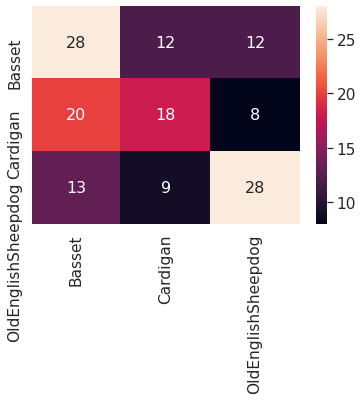

In [32]:
print(f'----- Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f} % -----')

df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), small_directory_names, small_directory_names)
# plt.figure(figsize=(10,7))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size

plt.show()